1. Список аэропортов, куда есть рейсы из Анапы:

SELECT DISTINCT f.arrival_airport airport_code,
                a.airport_name,
                a.city,
                a.latitude,
                a.longitude
FROM dst_project.flights f
JOIN dst_project.airports a ON f.arrival_airport=a.airport_code
WHERE f.departure_airport = 'AAQ'
  AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01',
                                                      '2017-02-01',
                                                      '2017-12-01'))
  AND f.status not in ('Cancelled')


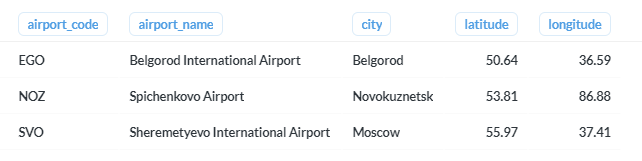

2. Модели самолетов, которые летают из Анапы:

SELECT DISTINCT f.aircraft_code,
                a.model,
                a.range
FROM dst_project.flights f
JOIN dst_project.aircrafts a ON a.aircraft_code=f.aircraft_code
WHERE f.departure_airport = 'AAQ'
  AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01',
                                                      '2017-02-01',
                                                      '2017-12-01'))
  AND f.status not in ('Cancelled')

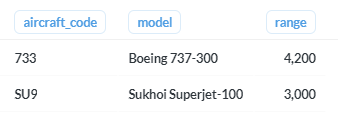

3. Расстояние между аэропортами:

Для расчета длины между двумя точками использовалась формула по данной ссылке: https://stackoverflow.com/questions/61135374/postgresql-calculate-distance-between-two-points-without-using-postgis/65739481#65739481

Посколько прав на создание функций не было, то пришлось заинлайнить функцию как:
acos(sin(pi() * lat1 / 180) * sin(pi() * lat2 / 180) + cos(pi() * lat1 / 180) * cos(pi() * lat2 / 180) * cos(pi() * (lon1 - lon2) / 180)) * 180 / pi() * 60 * 1.1515 * 1.609344

Получаем SQL:

SELECT a1.airport_code,
       a1.latitude latitude1,
       a1.longitude longitude1,
       a2.latitude latitude2,
       a2.longitude longitude2,
       acos(sin(pi() * a1.latitude / 180) * sin(pi() * a2.latitude / 180) + cos(pi() * a1.latitude / 180) * cos(pi() * a2.latitude / 180) * cos(pi() * (a1.longitude - a2.longitude) / 180)) * 180 / pi() * 60 * 1.1515 * 1.609344 distance_km
FROM dst_project.airports a1
JOIN dst_project.airports a2 ON a2.airport_code='AAQ'
WHERE a1.airport_code in ('EGO',
                          'NOZ',
                          'SVO')
ORDER BY distance_km


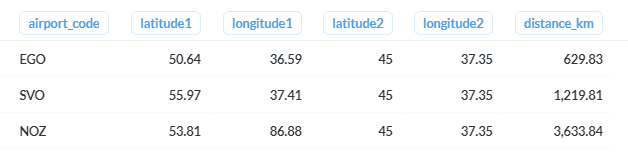

4. Получение датасета:

WITH total_amount AS
  (SELECT a.flight_id,
          sum(a.total_amount) total_amount
   FROM
     (SELECT f.flight_id,
             b.book_ref,
             min(b.total_amount) total_amount
      FROM dst_project.ticket_flights tf
      JOIN dst_project.flights f ON f.flight_id = tf.flight_id
      JOIN dst_project.tickets t ON t.ticket_no = tf.ticket_no
      JOIN dst_project.bookings b ON b.book_ref = t.book_ref
      WHERE f.departure_airport = 'AAQ'
        AND (date_trunc('month', f.scheduled_departure) in ('2017-01-01',
                                                            '2017-02-01',
                                                            '2017-12-01'))
        AND f.status not in ('Cancelled')
      GROUP BY f.flight_id,
               b.book_ref) a
   GROUP BY a.flight_id),
     airport_distance AS
  (SELECT a1.airport_code,
          acos(sin(pi() * a1.latitude / 180) * sin(pi() * a2.latitude / 180) + cos(pi() * a1.latitude / 180) * cos(pi() * a2.latitude / 180) * cos(pi() * (a1.longitude - a2.longitude) / 180)) * 180 / pi() * 60 * 1.1515 * 1.609344 distance_km
   FROM dst_project.airports a1
   JOIN dst_project.airports a2 ON a2.airport_code='AAQ'
   WHERE a1.airport_code in ('EGO',
                             'NOZ',
                             'SVO')),
     fuel_consumption AS
  (SELECT '733' aircraft_code,
                3.46 fuel_consumption_100km
   UNION ALL SELECT 'SU9' aircraft_code,
                          3.59 fuel_consumption_100km),
     seat_count AS
  (SELECT aircraft_code,
          count(seat_no) seat_count
   FROM dst_project.seats
   WHERE aircraft_code in ('733',
                           'SU9')
   GROUP BY aircraft_code)
SELECT f.flight_id,
       f.flight_no,
       f.scheduled_departure,
       a.model,
       f.arrival_airport,
       s.seat_count,
       d.distance_km,
       coalesce(ta.total_amount, 0) total_amount
FROM dst_project.flights f
JOIN airport_distance d ON f.arrival_airport=d.airport_code
JOIN fuel_consumption c ON c.aircraft_code=f.aircraft_code
JOIN seat_count s ON s.aircraft_code=f.aircraft_code
JOIN dst_project.aircrafts a ON a.aircraft_code=f.aircraft_code
LEFT JOIN total_amount ta ON ta.flight_id = f.flight_id
WHERE departure_airport = 'AAQ'
  AND (date_trunc('month', scheduled_departure) in ('2017-01-01',
                                                    '2017-02-01',
                                                    '2017-12-01'))
  AND status not in ('Cancelled')
ORDER BY total_amount

Мы получили информацию о 127 рейсах в таком формате:

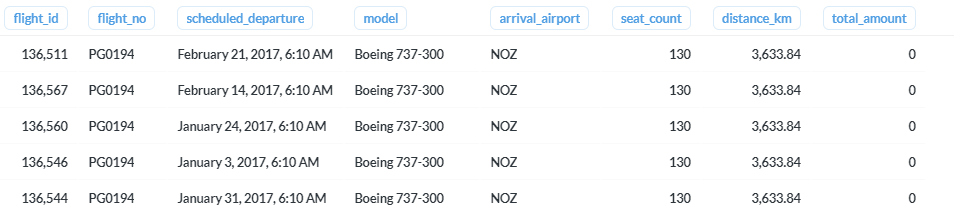

Полный датасет сохранен в anapa_flights.xlsx